In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [18]:
import numpy as np

import torch
torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt

import chemiscope

import metatensor.torch as mts

from mlelec.data.qmdataset import QMDataset

In [10]:
workdir = '/scratch/pegolo/tutorial'
every = 50

In [11]:
orbitals = {
     'sto-3g': {
         6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]
     }, 
}

basis = 'sto-3g'

In [87]:
qmdata = QMDataset.from_file(
    frames_path = f'{workdir}/C2.xyz', 
    fock_realspace_path = f'{workdir}/{basis}/graphene_fock.npy', 
    overlap_realspace_path = f'{workdir}/{basis}/graphene_ovlp.npy',
    kmesh_path = f'{workdir}/{basis}/kmesh.dat',
    dimension = 2, 
    device = 'cpu', 
    orbs_name=basis, 
    orbs=orbitals[basis], 
    frame_slice = f'::{every}',
)

In [16]:
H = qmdata.fock_realspace[0][0,0,0]

In [20]:
blocks = get_targets(qmdata, orbitals_to_properties=True)

/home/pegolo/Software/mlelec/src/mlelec/utils/pbc_utils.py:114: UserWarning: Automatic choice of the cutoff for structure 0. rcut = 8.35 Angstrom
  warnings.warn(f'Automatic choice of the cutoff for structure {A}. rcut = {cutoff:.2f} Angstrom')
/home/pegolo/Software/mlelec/src/mlelec/utils/pbc_utils.py:114: UserWarning: Automatic choice of the cutoff for structure 1. rcut = 8.35 Angstrom
  warnings.warn(f'Automatic choice of the cutoff for structure {A}. rcut = {cutoff:.2f} Angstrom')
/home/pegolo/Software/mlelec/src/mlelec/utils/pbc_utils.py:114: UserWarning: Automatic choice of the cutoff for structure 2. rcut = 8.35 Angstrom
  warnings.warn(f'Automatic choice of the cutoff for structure {A}. rcut = {cutoff:.2f} Angstrom')
/home/pegolo/Software/mlelec/src/mlelec/utils/pbc_utils.py:114: UserWarning: Automatic choice of the cutoff for structure 3. rcut = 8.35 Angstrom
  warnings.warn(f'Automatic choice of the cutoff for structure {A}. rcut = {cutoff:.2f} Angstrom')


In [137]:
from mlelec.utils.symmetry import _wigner_d_real, _rotation_matrix_from_angles, rotate_frame
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.target_utils import get_targets

from ase.visualize.plot import plot_atoms
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation

In [54]:
import numpy as np

def lissajous_euler(t, a=1.0, b=1.0, delta=np.pi/2, frequency=1.0, tilt_amplitude=np.pi/8, tilt_frequency=0.1):
    """
    Generate Euler angles to rotate a 3D vector along a smooth, periodic Lissajous-like trajectory.

    Parameters:
    - t: Time or parameter (float).
    - a: Amplitude of the Lissajous curve in the X direction (float).
    - b: Amplitude of the Lissajous curve in the Y direction (float).
    - delta: Phase difference between X and Y (float).
    - frequency: Base frequency of the Lissajous motion (float).
    - tilt_amplitude: The maximum tilt angle of the trajectory plane (float).
    - tilt_frequency: How fast the tilt axis precesses over time (float).

    Returns:
    - Euler angles (theta_z, theta_y, theta_x) in radians (tuple of floats).
    """

    # Parametric equations for a Lissajous curve
    x = a * np.sin(frequency * t + delta)
    y = b * np.sin(2 * frequency * t)
    z = np.sin(frequency * t)
    
    # Compute the tilt in the plane over time
    tilt_angle = tilt_amplitude * np.sin(tilt_frequency * t)
    
    # Apply the tilt to the trajectory
    x_tilted = x * np.cos(tilt_angle) - z * np.sin(tilt_angle)
    z_tilted = x * np.sin(tilt_angle) + z * np.cos(tilt_angle)
    
    # Tangent vector of the tilted trajectory
    dx = a * frequency * np.cos(frequency * t + delta)
    dy = 2 * b * frequency * np.cos(2 * frequency * t)
    dz = frequency * np.cos(frequency * t)
    
    dx_tilted = dx * np.cos(tilt_angle) - dz * np.sin(tilt_angle)
    dz_tilted = dx * np.sin(tilt_angle) + dz * np.cos(tilt_angle)
    
    # Calculate the Euler angles
    theta_z = np.arctan2(dy, dx_tilted)  # Rotation around Z axis
    theta_y = np.arctan2(dz_tilted, np.sqrt(dx_tilted**2 + dy**2))  # Rotation around Y axis
    theta_x = 0  # Rotation around X axis (can be modified if needed)
    
    return theta_z, theta_y, theta_x

In [88]:
idx = 0
init_frame = qmdata.structures[idx].copy()
cell = init_frame.cell.array
cell[2, 2] = 1
init_frame.set_cell(cell)
func = lissajous_euler
ang = [func(frame) for frame in np.linspace(0, 2 * np.pi, 200)]
rotations = [_rotation_matrix_from_angles(*a) for a in ang]
rot_structures = [rotate_frame(init_frame, r) for r in rotations]

In [89]:
rotated_tmaps = []
for i, rot in enumerate(ang):
    r_blocks = []
    for k, b in blocks.items():
        L = k['L']
        b0 = mts.slice_block(b, axis='samples', labels=mts.Labels(["structure"], torch.tensor([idx]).reshape(1,1)))
        wd = _wigner_d_real(L, *rot)    
        block_values = torch.einsum('ab,sbp->sap', wd, b0.values)
        r_block = mts.TensorBlock(
            values = block_values,
            samples = b0.samples, 
            properties = b0.properties, 
            components = b0.components,
        )
        r_blocks.append(r_block)
    rotated_tmaps.append(
        mts.TensorMap(
            blocks.keys,
            r_blocks
        )
    )

In [91]:
rot_H = []
for i in range(len(rotated_tmaps)):
    rot_H.append(blocks_to_matrix(rotated_tmaps[i], orbitals['sto-3g'], {0: rot_structures[i]}, detach=True, check_hermiticity=True))

In [134]:

for i in range(len(rot_structures)):
    fig, axes = plt.subplots(1, 2, figsize = (6, 3))
    
    for ax in axes:
        ax.set_aspect('equal')
        ax.set_axis_off()
    
    ax = axes[0]
    plot_atoms(rot_structures[i], ax=ax)
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    
    ax = axes[1]
    ax.matshow(np.abs(rot_H[i][0][0,0,0]), norm=LogNorm(vmin=1e-5, vmax=10))
    
    fig.tight_layout()
    fig.savefig(f'rot_anim/rot_{i:>03}.png', dpi = 300)
    print(i, end=' ')
    plt.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [149]:
def plot_frame(i):
    # Clear the axes
    for ax in axes:
        ax.clear()
        ax.set_aspect('equal')
        ax.set_axis_off()

    # Plot the first subplot
    ax = axes[0]
    plot_atoms(rot_structures[i], ax=ax)  # Assuming plot_atoms is a user-defined function
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)

    # Plot the second subplot
    ax = axes[1]
    ax.matshow(np.abs(rot_H[i][0][0, 0, 0]), norm=LogNorm(vmin=1e-5, vmax=10))

    # Adjust the layout
    fig.tight_layout()

In [ ]:
# Setup the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Create the animation
anim = FuncAnimation(fig, plot_frame, frames=len(rot_structures), interval=200)

In [136]:
from IPython.display import HTML
HTML(anim.to_jshtml())

In [142]:
from mlelec.utils.animation import lissajous_euler, rotated_matrices

In [150]:
rot_struc, rot_H = rotated_matrices(init_frame, blocks, 0, orbitals['sto-3g'], lissajous_euler, params=np.linspace(0, 2 * np.pi, 200))

In [151]:
def plot_frame(i):
    # Clear the axes
    for ax in axes:
        ax.clear()
        ax.set_aspect('equal')
        ax.set_axis_off()

    # Plot the first subplot
    ax = axes[0]
    plot_atoms(rot_struc[i], ax=ax)  # Assuming plot_atoms is a user-defined function
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)

    # Plot the second subplot
    ax = axes[1]
    ax.matshow(np.abs(rot_H[i][0][0, 0, 0]), norm=LogNorm(vmin=1e-5, vmax=10))

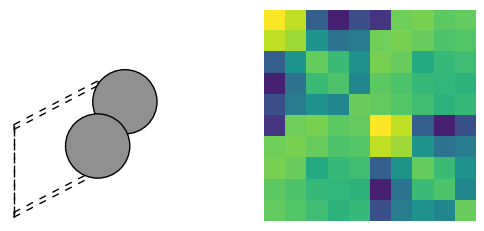

In [153]:
# Setup the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Create the animation
anim = FuncAnimation(fig, plot_frame, frames=len(rot_structures), interval=200)

from IPython.display import HTML
HTML(anim.to_jshtml())